Validation of CameraCalibration class.

In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
corners = None

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)               # Read to RGB pixel format
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
 
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()
# Clean up workspace: keep only objpoints and imgpoints
del corners, gray, images, objp

from classes import CameraCalibration
cal = CameraCalibration(imgpoints = imgpoints, objpoints = objpoints, img_size=(1280,720))
cal.save('camera_cal/validation.p')

In [ ]:
from classes import CameraCalibration
cal = CameraCalibration('camera_cal/validation.p')
print("Camera center:",cal.get_ahead(0)," get_center() =",cal.get_center())

cal.set_camera_height(1.44)  # Advanced Lane Lines with 3.7 m lane width assumption
cal.set_ahead(638,418)
print(cal.lane())

Validation of CameraCalibration. 

Testing undistort and handling of image collections.

RGBA image shape: (720, 1280, 4) and size: (1280, 720)
Extract G and B channels: shape = (720, 1280, 2)
Children of rgba =
 ['(( channels, 1, 3 ))', '(( undistort, <classes.CameraCalibration.CameraCalibration object at 0x7f23cd75e6a0> ))']
(('channels', (1, 3)),)
(('undistort', (<classes.CameraCalibration.CameraCalibration object at 0x7f23cd75e6a0>,)),)
RoadImage.channels: The selected range of channels must not be empty.


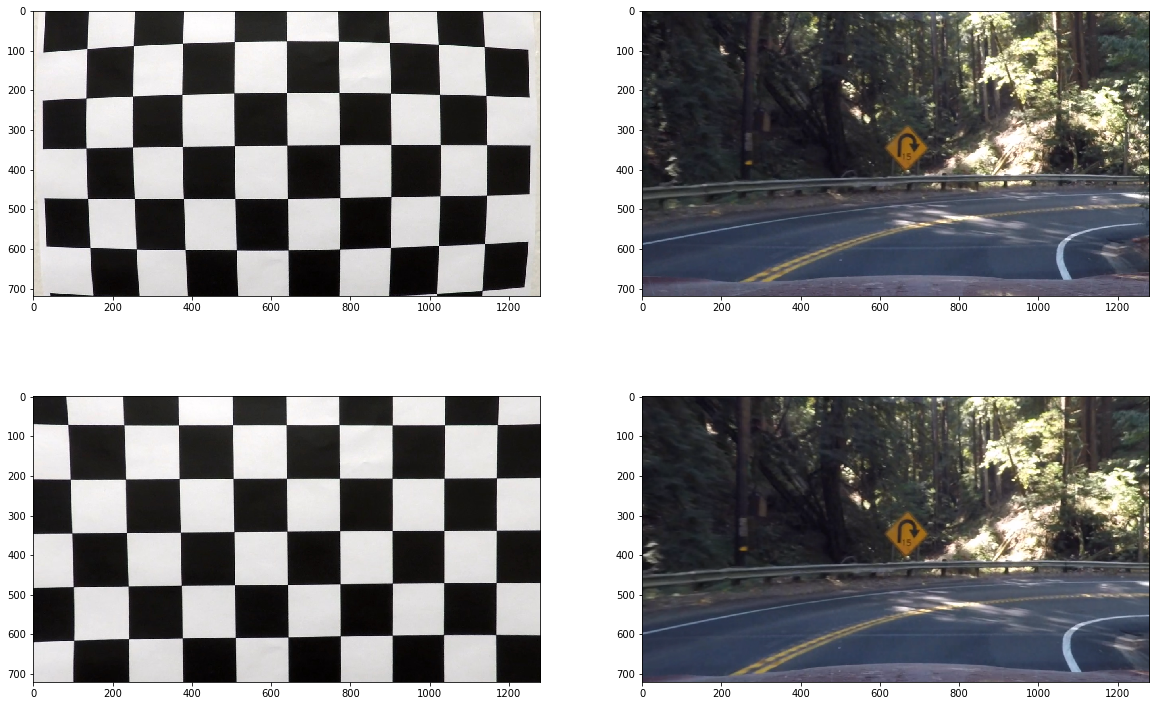

In [1]:
from classes import RoadImage, CameraCalibration
import numpy as np

# Flatten() creates a collection of 1 image (shape (1,720,1280,3))
img = RoadImage(filename='camera_cal/calibration1.jpg').flatten()
cal = CameraCalibration('camera_cal/validation.p')

from trace import Trace
tr = Trace()
#cover = tr.run("undist = img.undistort(cal)")
#print(cover)
undist = img.undistort(cal)

# Load RGBA image
rgba = RoadImage(filename='training/hard_turn_annotated.png')
print('RGBA image shape:',rgba.shape, 'and size:', rgba.get_size())
rgbaundist = rgba.undistort(cal)
rgbaundist.save('training/hard_turn_undistorted.png')
gb = rgba.channels(1,3)
print('Extract G and B channels: shape =',gb.shape)
print('Children of rgba =\n', rgba.list_children())
print(gb.find_op(rgba))
print(rgbaundist.find_op(rgba))
#import numpy as np
# Test below is filtered by @strict_accepts
#try:
#    # Pass a non-hashable number to channels to exercise generic search
#    rgba.channels(np.array([1.3]),2)
#except TypeError as e:
#    print(str(e))
    
# Pass a bad channel number to channels to exercise error checking
try:
    rgba.channels(2,2)
except ValueError as e:
    print(str(e))
    
import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,13))
ax1.imshow(img[0])
ax3.imshow(undist[0])
rgba[:,:,0:3].show(ax2)         # exercise rgba.rgb() indirectly to discard alpha layer
rgbaundist.show(ax4, alpha=False)

Validation of RoadImage class.
Constructor, numpy interoperability, cropping and casting.

3x3 input seen as 3 color pixels. Nb of channels = 3
Invert red and blue channels
c.parent is None: False
c.parent is child of d: True
c.crop_area: ((0, 0, 0), (100, 200, 3))
d_child.crop_area: ((400, 540, 0), (500, 740, 3))
d.get_crop(d): ((0, 0), (1280, 720))
c.shape: (100, 200, 3)
c.size: 60000
p.shape and e.get_crop(e,parents...): (100, 200, 3) ((50, 25), (150, 75))
p.shape and e.get_crop(e,parents...): (100, 200, 3) ((50, 25), (150, 75))
p.shape and e.get_crop(e,parents...): (720, 1280, 3) ((590, 425), (690, 475))
Children of d =
[['(( crop, (400, 540, 0), (500, 740, 3) ))', [["(( convert_color, 'LAB' ))", ['(( crop, (25, 50, 0), (75, 150, 3) ))']]]]]
g #ch: 3  colorspace: RGB


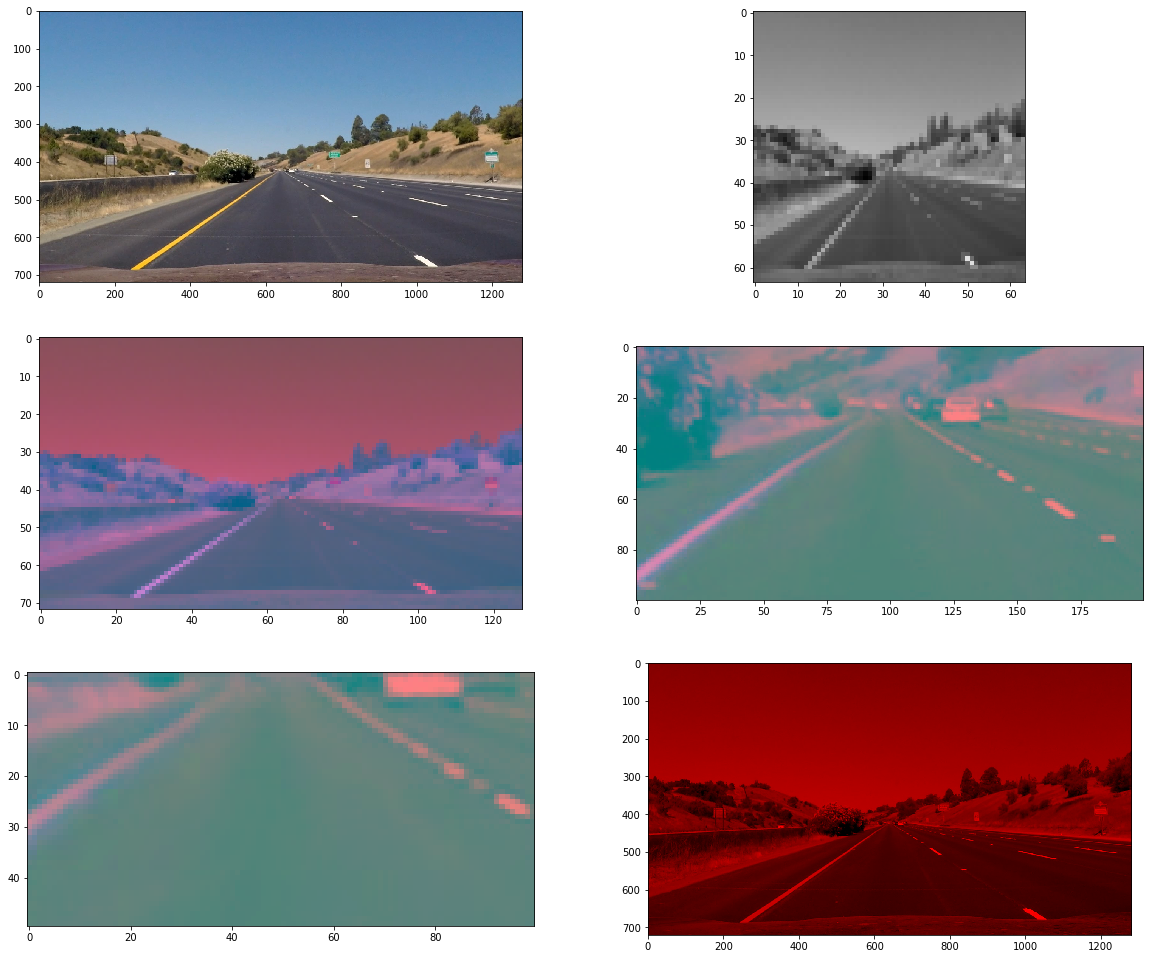

In [2]:
import numpy as np
from classes import RoadImage

# Correctly handle ambiguous vector of RGB values: silently accepted if src_cspace is given.
k= RoadImage(np.zeros(shape=(3,3)), src_cspace='RGB')
# Seen as RGB vector of pixels
print('3x3 input seen as 3 color pixels. Nb of channels =',RoadImage.image_channels(k))

# Load from file demo
d = RoadImage(filename='test_images/straight_lines1.jpg')
print('Invert red and blue channels')
e = d.channels(range(2,-1,-1)) # Invert red and blue

# Load from file into existing buffer, resizing, convert to gray, convert dtype automatically
b = RoadImage(filename='test_images/straight_lines1.jpg')\
                    .to_float().resize(w=64,h=64).to_grayscale()
# Load from file into existing buffer, resizing, convert colorspace to LUV.
a = RoadImage(filename='test_images/straight_lines1.jpg')\
       .to_int().resize(w=128,h=72).convert_color('LUV')

# Extract subimage
#c = d.convert_color('LAB')[400:500, 540:740]
c = d[400:500, 540:740].convert_color('LAB')
#print(d.list_children())
d_child = d.find_child(((RoadImage.crop,((400,540,0),(500,740,3))),))
print('c.parent is None:',c.parent is None)
print('c.parent is child of d:',c.parent is d_child)
print('c.crop_area:',c.crop_area)
print('d_child.crop_area:',d_child.crop_area)
print('d.get_crop(d):', d.get_crop(d))
print('c.shape:',c.shape)
print('c.size:',c.size)

e = c[25:75, 50:150]
for p in e.parents():
#    print(e.find_op(p, normal=True))
    print('p.shape and e.get_crop(e,parents...):',p.shape, e.get_crop(p))

print('Children of d =')
print(d.list_children())

f = d.channel(1) # Green channel
g = f.rgb()      # Green to red, zero green and blue
print('g #ch:', RoadImage.image_channels(g), ' colorspace:',g.colorspace)
import matplotlib.pyplot as plt
%matplotlib inline


fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(20,17))
# Load from file
ax1.imshow(d)
# Load to existing buffer: resize 64x64 convert to grayscale float32
b.show(ax2,cmap='gray')
# Load to existing buffer: resize 128x72x3 uint8, convert colorspace to LUV  
ax3.imshow(a)
# Crop to zoom on distant road, convert colormap from LUV to LAB
ax4.imshow(c)
# Inverse Red and Blue channels
e.show(ax5)
# Extend single channel Green to RGB by appending 2 zero channels
g.show(ax6)

Validation of RoadImage class.

Locking / unlocking of parents.

In [3]:
from classes import RoadImage
import numpy as np
import warnings
warnings.simplefilter("always")

# Crop, flatten and channel do not make parent read-only
k= RoadImage(np.zeros(shape=(2,2,1)), src_cspace='GRAY')
k.binary=False
print('k is writeable:', k.flags.writeable)
c=k[0:1]
print('c.shape =',c.shape)
print('c.crop_area =',c.get_crop(k))
f=k.flatten()
print(k.list_children())
print('k.flatten().shape =',f.shape)
ch=k.channel(0)
print('k.channel(0).shape =',ch.shape)
print('k.channel(0).crop_area =',ch.get_crop(k))
print('k is writeable:', k.flags.writeable)
print('k is binary:', k.flatten().binary)

# Test that in-place normalization is rejected when there are children
n=k.normalize()
try:
    k.normalize(inplace=True)
except ValueError as e:
    print(str(e))
    
# Test in-place normalization on new child of k
l=(2+k).channel(0)
l.normalize(inplace=True)
print('Long op:',l.find_op())
print(l)
print('in-place done')
del l

print('normalize zeros:\n')#,n.__repr__())
print('k is writeable:', k.flags.writeable)
print(k.list_children())
raw=False
print('crop op:',c.find_op(k, raw=raw))
print('flatten_op:',f.find_op(k, raw=raw))
print('channel_op:',ch.find_op(k, raw=raw))
print('normalize_op:',n.find_op(k, raw=raw))
print('k has only auto-updating children:',RoadImage.__has_only_autoupdating_children__(k))
try:
    k[0,0] = 1
except ValueError:
    print('Writing into k generates an exception.')
print('deleting hard reference to n.')
del n
print('k has only auto-updating children:',RoadImage.__has_only_autoupdating_children__(k))
k[0,0]=1
print(k)

k is writeable: True
c.shape = (1, 2, 1)
c.crop_area = ((0, 0), (2, 1))
['(( crop, (0, 0, 0), (1, 2, 1) ))', '(( flatten ))']
k.flatten().shape = (1, 2, 2, 1)
k.channel(0).shape = (2, 2, 1)
k.channel(0).crop_area = ((0, 0), (2, 2))
k is writeable: True
k is binary: False
RoadImage.normalize: in-place operation is only allowed when there is no child.
Long op: (('channels', (range(0, 1),)), ('normalize',))
[[[ 1.]
  [ 1.]]

 [[ 1.]
  [ 1.]]]
in-place done
normalize zeros:

k is writeable: False
['(( crop, (0, 0, 0), (1, 2, 1) ))', '(( flatten ))', '(( normalize ))', '(( channels, range(0, 1) ))']
crop op: (('crop', ((0, 0, 0), (1, 2, 1))),)
flatten_op: (('flatten',),)
channel_op: (('channels', (range(0, 1),)),)
normalize_op: (('normalize',),)
k has only auto-updating children: False
Writing into k generates an exception.
deleting hard reference to n.
k has only auto-updating children: True
[[[ 1.]
  [ 0.]]

 [[ 0.]
  [ 0.]]]


Validation of RoadImage class. 

Color conversion. Children and parents.

No children yet: []
Colorspace is: RGB

Memorization test 1: unreferenced temporaries are discarded and rebuilt.
Elapsed time: 0.007375240325927734
Elapsed time: 0.0045261383056640625

Memorization test 2: referenced images are linked and reused (time is shorter).
Elapsed time: 0.004431486129760742
Elapsed time: 3.695487976074219e-05
Only one child:  ["(( convert_color, 'YCC' ))"]
b.find_op(): (('convert_color', ('YCC',)),)
b.parent is a: True
c: ((0, 0, 0), (720, 1280, 3))
d.shape = (720, 1280, 1)
Children:  [["(( convert_color, 'YCC' ))", [["(( convert_color, 'RGB' ))", ['(( to_grayscale ), ( normalize ))']]]]]
b.parent is a: True
c.parent is b: True
d.parent is c: True
d was built with: (('to_grayscale',), ('normalize',))
a to d ops: (('convert_color', ('YCC',)), ('convert_color', ('RGB',)), ('to_grayscale',), ('normalize',))
c.shares_data?  False
c.parent is b: False
d.parent is c: True


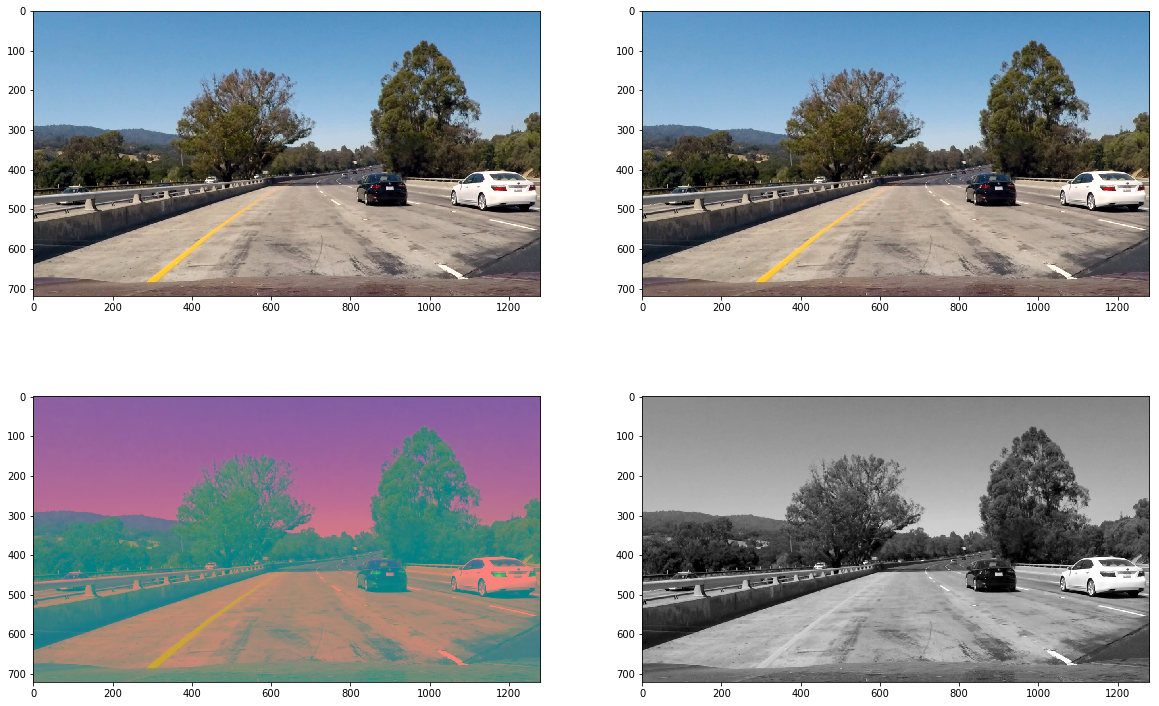

In [4]:
# Define a timing decorator
from functools import wraps
from time import time


def timing(f):
    @wraps(f)
    def wrapper(*args, **kwargs):
        start = time()
        result = f(*args, **kwargs)
        end = time()
        print('Elapsed time: {}'.format(end-start) )
        return result
    return wrapper


from classes.RoadImage import RoadImage
a = RoadImage(filename='test_images/test1.jpg')
print('No children yet:',a.list_children())
print('Colorspace is: '+a.colorspace)

print('\nMemorization test 1: unreferenced temporaries are discarded and rebuilt.')
@timing
def f():
    a.convert_color('YCC')
   
# Check that convert_color is destroyed and rebuilt
f()
f()

print('\nMemorization test 2: referenced images are linked and reused (time is shorter).')
@timing
def g():
    return a.convert_color('YCC')

b = g()
b = g()

print('Only one child: ',a.list_children())
print('b.find_op():',b.find_op())
print('b.parent is a:',b.parent is a)
b = a.find_child(b.find_op(raw=True))
assert not(b is None) , 'b should not be None'
b = a.find_child(b.find_op(raw=False))
assert not(b is None) , 'b should not be None'
c = b.convert_color('RGB')
print('c:',c.crop_area)
d = c.to_grayscale().normalize(inplace=True)
print('d.shape =',d.shape) 
print('Children: ',a.list_children())

print('b.parent is a:',b.parent is a)
print('c.parent is b:',c.parent is b)
print('d.parent is c:',d.parent is c)
print('d was built with:',d.find_op())
print('a to d ops:',d.find_op(a))
# Can unlink c which does not share data with parent
print('c.shares_data? ',c.shares_data())
c.unlink()
print('c.parent is b:',c.parent is b)
print('d.parent is c:',d.parent is c)

import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,13))
# Image from file (RGB)
a.show(ax1)
# Image from file converted to YCC, then back to RGB
c.show(ax2)
# YCC image
b.show(ax3)
# Grayscale image
d.show(ax4)

Validation of RoadImage class. 

Conversion to float and to int

No children yet: []
Data type is: uint8
Children:  [['(( to_float ))', ['(( to_int ))']]]
Is a, parent of b? True
Is b, a? False
Is a, parent of c? False
Is c, a? True
Is c parent of d? False
Is b, d? False
a to d ops: (('to_float',), ('to_int',))


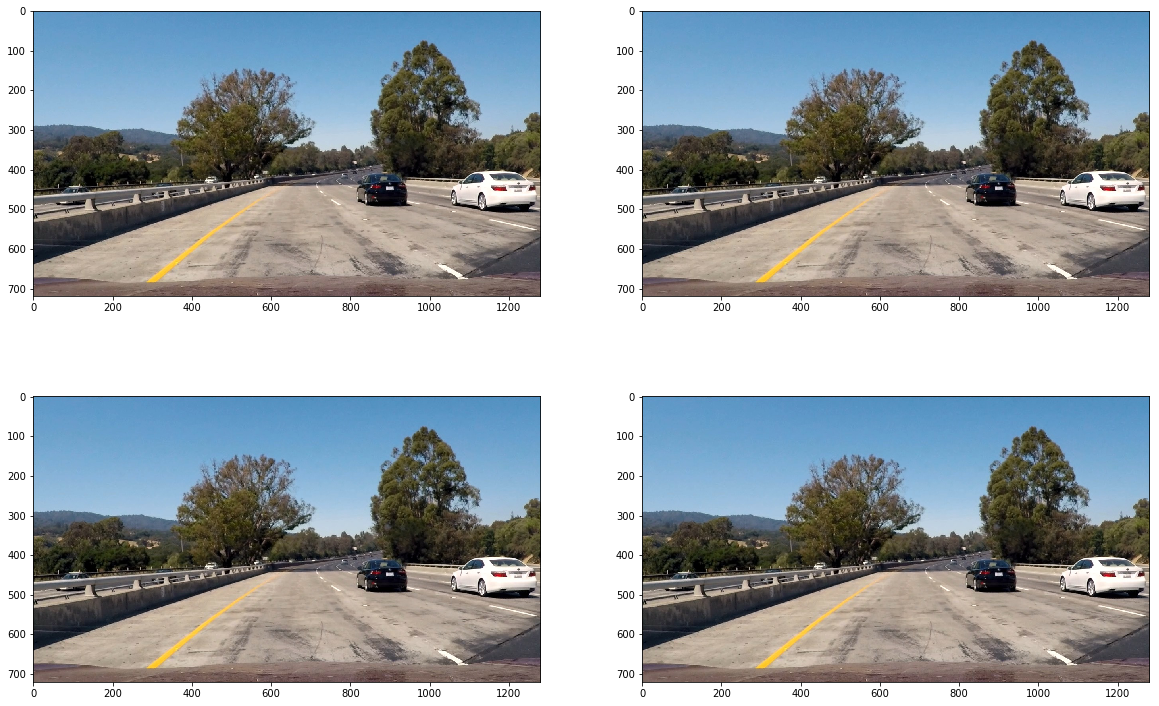

In [5]:
from classes.RoadImage import RoadImage
a = RoadImage(filename='test_images/test1.jpg')
print('No children yet:',a.list_children())
print('Data type is: '+str(a.dtype))

b = a.to_float()
c = a.to_int()
d = b.to_int()
print('Children: ',a.list_children())

print('Is a, parent of b?',b.parent is a)
print('Is b, a?',b is a)
print('Is a, parent of c?',c.parent is a)
print('Is c, a?',c is a)
print('Is c parent of d?',d.parent is c)
print('Is b, d?',d is b)
print('a to d ops:',d.find_op(a))

import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,13))
# Image from file (uint8) 
a.show(ax1)
# float converted
b.show(ax2)
# int converted
c.show(ax3)
# int to float, back to int converter
d.show(ax4)

Validation of RoadImage class. Per channel operations (gradient, normalize).

Take opportunity of large number of generated children to test find_common_ancestor

(720, 1280, 3)
(1, 720, 1280, 3)
True
False
((0, 0, 0), (720, 1280, 3))
Children of img:  ['(( flatten ))']
(720, 1280, 3)
<class 'classes.RoadImage.RoadImage'>
Magnitude: min= 0.0  max= 0.6740993857383728
Normalized magnitude: min= 0.0  max= 1.0
((<function RoadImage.gradients at 0x7f23cd7d4ae8>, ('angle', 9, 0.04)),)
Children of img:  ["(( gradients, 'mag', 9, 0.04 ), ( normalize, perchannel=True ))", "(( gradients, 'x', 9, 0.04 ), ( normalize, perchannel=True, perline=True ))", "(( gradients, 'angle', 9, 0.04 ))", '(( flatten ))', "(( gradients, 'y', 9, 0.04 ), ( normalize, perchannel=True, perline=True ))"]

find_common_ancestors( [grada, gradm, gradx, grady, copy of gradm]):

ancestors and index:
0 	 (720, 1280, 3)
1 	 (720, 1280, 3)
[0, 0, 0, 0, 1]

operations from ancestor to list element:
(('gradients', ('angle', 9, 0.04)),)
(('gradients', ('mag', 9, 0.04)), ('normalize', (<class 'dict'>, ('perchannel', True))))
(('gradients', ('x', 9, 0.04)), ('normalize', (<class 'dict'>, ('p

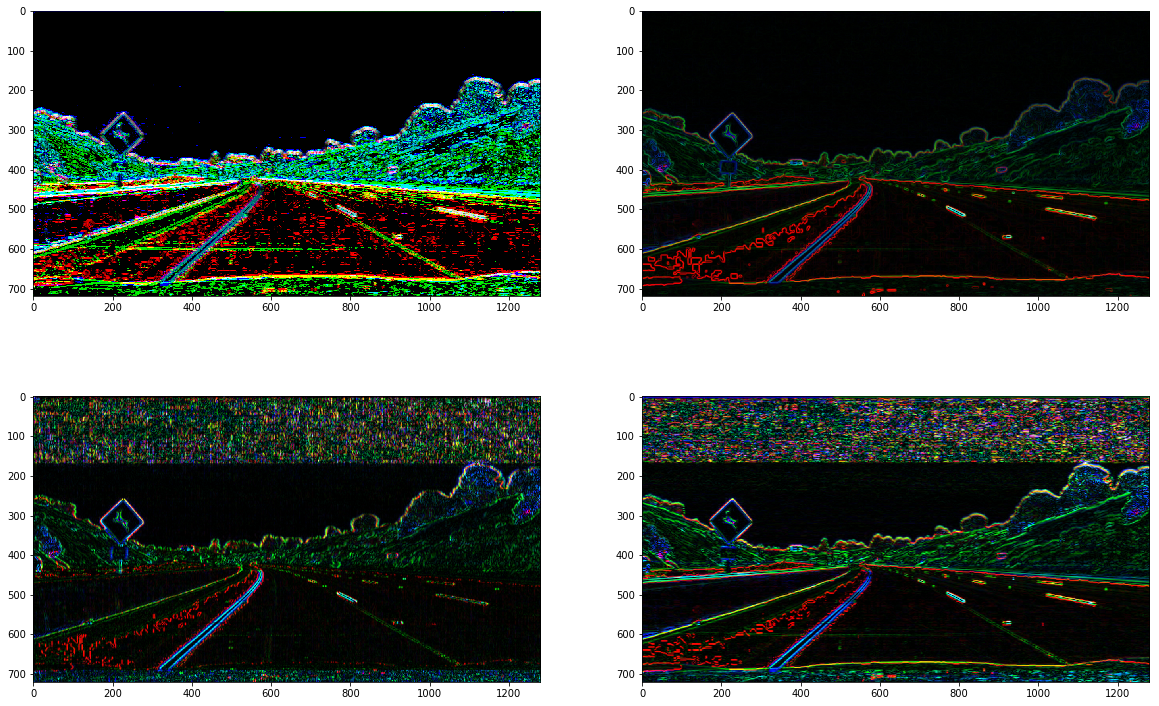

In [6]:
from classes.RoadImage import RoadImage

img = RoadImage(filename='test_images/test2.jpg', cspace='HLS')
print(img.shape)
f1 = img.flatten()
f2 = f1.flatten()
print(f2.shape)
print(f2 is f1)
print(f1 is img)
print(f1.crop_area)
print('Children of img: ', img.list_children())
grads = img.gradients(['angle','mag','x','y'], sobel_kernel=9)
(a,m,x,y) = grads
print(a.shape)
print(type(a))

import numpy as np
print("Magnitude: min=",np.min(m),' max=',np.max(m))
m.normalize(perchannel=True, inplace=True)
print("Normalized magnitude: min=",np.min(m),' max=',np.max(m))
x.normalize(perchannel=True, perline=True, inplace=True)
y.normalize(perchannel=True, perline=True, inplace=True)
print(a.find_op(raw=True))
print('Children of img: ', img.list_children())

print('\nfind_common_ancestors( [grada, gradm, gradx, grady, copy of gradm]):')
mcopy = m.copy()
lst = grads + [mcopy]
ancestors, index = RoadImage.find_common_ancestor(lst)
print('\nancestors and index:')
for i, anc in enumerate(ancestors): print(i,'\t',anc.shape)
print(index)
print('\noperations from ancestor to list element:')
for i,image in enumerate(lst):
    print(image.find_op(ancestors[index[i]]))

print('\nfind_common_ancestors( [x,x] )...', end='')
ancestors, index = RoadImage.find_common_ancestor([x,x])
print('passed')

print('Shape of gradients:', grads[0].shape)
# Make collection
print('\nmake_collection:')
coll = RoadImage.make_collection(grads)
print('coll.type =',type(coll))
print('coll.shape =',coll.shape)
print('coll.parent is img?', coll.parent is img)
print('long op from img:', coll.find_op(img, raw=False))

coll = RoadImage.make_collection([coll,coll], concat=True)
print('coll.shape =',coll.shape)

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,13))
# Angle of gradient 
a.show(ax1)
# Magnitude of gradient
ax2.imshow(m)
# x gradient
ax3.imshow(np.abs(x))
# y gradient
ax4.imshow(np.abs(y))

Validation of class RoadImage.

Validation of morphological methods: despeckle

Image shape: (100, 100, 1)
Image A binary? True
Image B binary? True


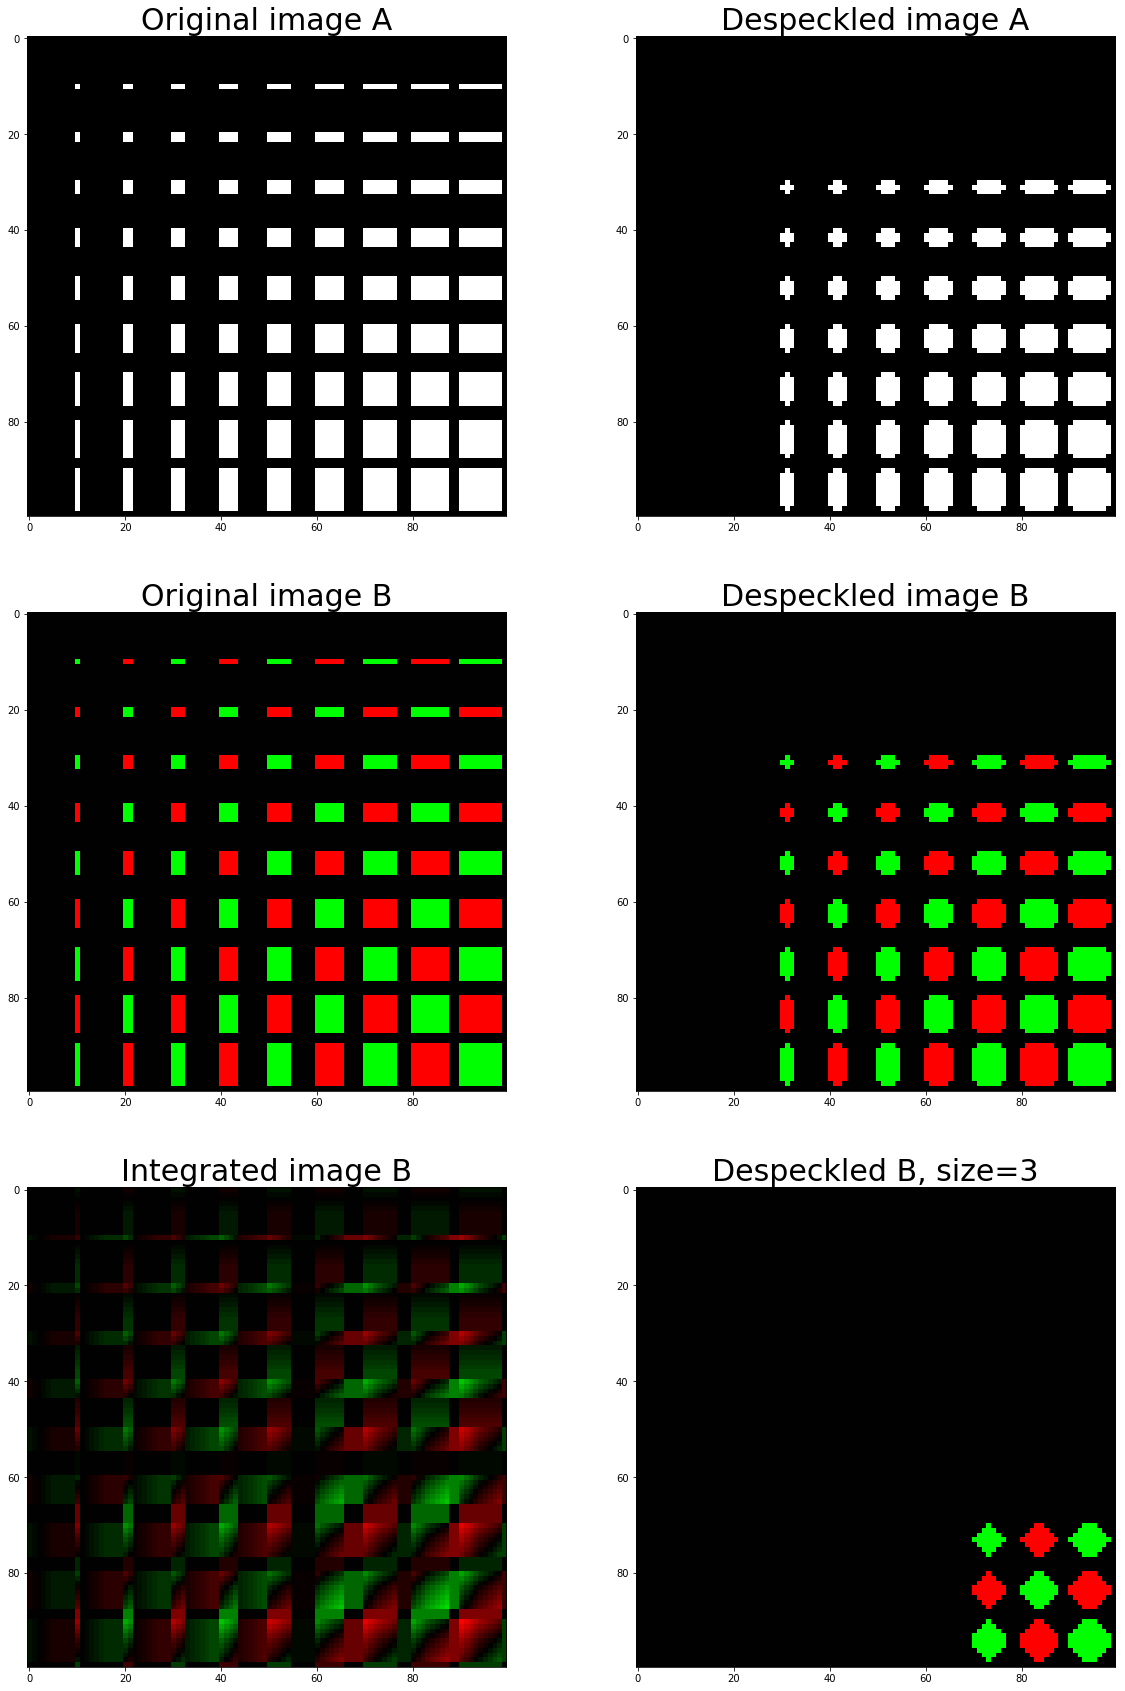

In [7]:
from classes import RoadImage
import numpy as np
import cv2

a = np.zeros(shape=(100,100), dtype=np.uint8)
b = np.zeros(shape=(100,100), dtype=np.float32)

# Draw dots of various sizes and shapes
for w,x in enumerate(range(10,100,10)):
    for h,y in enumerate(range(10,100,10)):
        cv2.rectangle(a, (x,y), (x+w,y+h), 1, -1, shift=0)
        if (w+h)%2==0: col=1
        else:          col=-1
        cv2.rectangle(b, (x,y), (x+w,y+h), col, -1, shift=0)

# Make RoadImage
imgA = RoadImage(a, src_cspace='GRAY')
print("Image shape:",imgA.shape)
imgB = RoadImage(b, src_cspace='GRAY')
imgB.gradient=True
print("Image A binary?", imgA.binary)
print("Image B binary?", imgB.binary)
imgE = imgB.integrate(ksize=100).normalize()

# Display img and masks as HLS
import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2), (ax3,ax4), (ax5,ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(20,30))
imgA.show(ax1, title='Original image A')
imgA.despeckle(inplace=True)
imgA.show(ax2, title='Despeckled image A')
imgB.show(ax3, title='Original image B')
imgC = imgB.despeckle(inplace=False)
imgC.show(ax4, title='Despeckled image B')
imgE.show(ax5, title='Integrated image B')
imgD = imgB.despeckle(size=3)
imgD.show(ax6, title='Despeckled B, size=3')

Validation of class RoadImage.

Validation of thresholding of images and gradients.

Loaded shape: (720, 1280, 3)
copy.dtype = uint8
copy.binary = True
copy.gradient = False
match_shape: (1, 1, 3)
mask colorspace: GRAY
mask is binary: True
mask.shape = (720, 1280, 1)
mask is grayscale: True
mask dtype: float32
DEBUG(serials): 8 to 9
min(g) = 0.0 max(g) = 1.0
a is gradient: False
m is gradient: False
x is gradient: True
g is gradient: True
g is binary: True
g is gradient: True
g is binary: True
g.shape = (1, 720, 1280, 1)


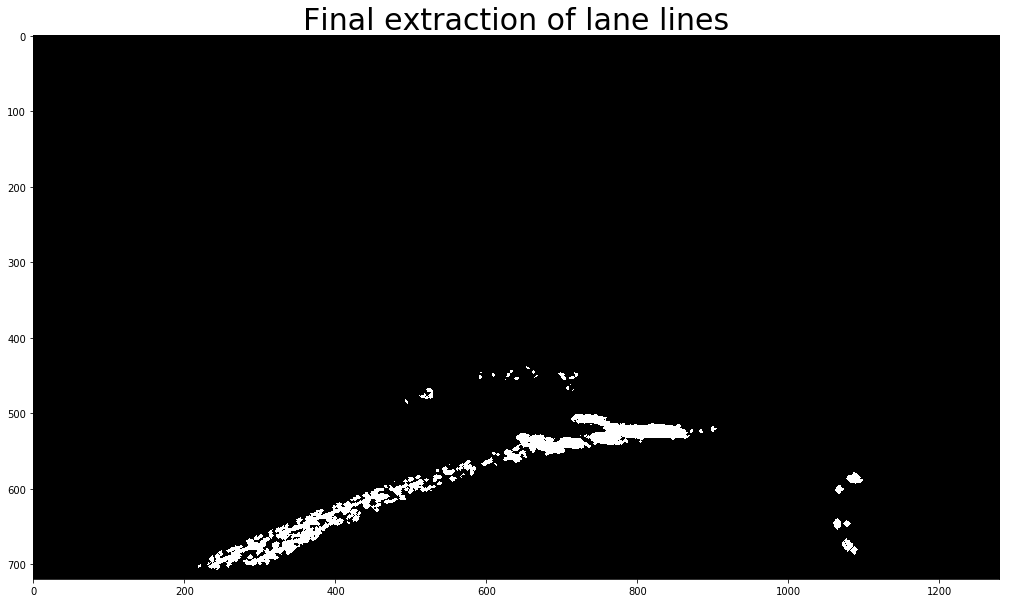

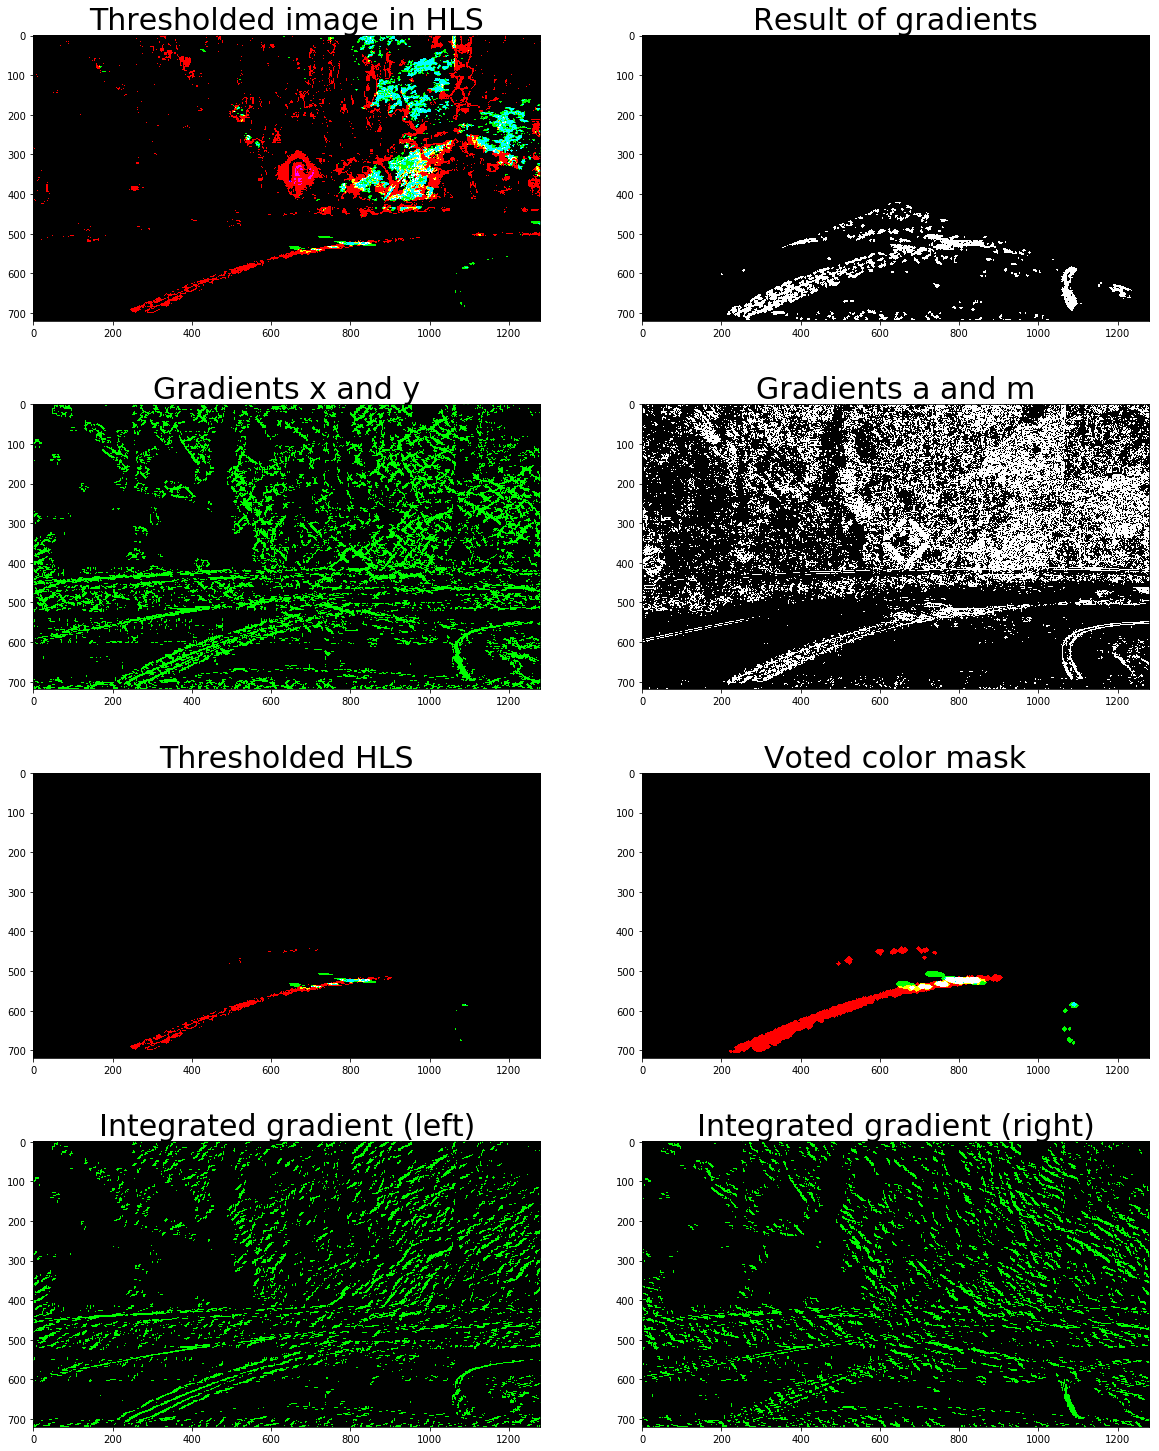

In [8]:
from classes import RoadImage, CameraCalibration
import numpy as np

cal = CameraCalibration('camera_cal/validation.p')

#crop = ((500,400),(780,500))
crop = ((0,0),(1280,720))
file = 'hard_turn'
#img = RoadImage(filename='test_images/straight_lines1.jpg',
img = RoadImage(filename='test_images/'+file+'.jpg',
                cspace='HLS').undistort(cal).crop(crop)
print('Loaded shape:',img.shape)
# We have per channel min and max (for H,L and S)
mini = np.array([0.0627, 0.762, 0.75])
maxi = np.array([0.0863, 1.0,   1.0])
copy = img.copy()
print('copy.dtype =',copy.dtype)
copy.threshold(mini=mini, maxi=maxi, inplace=True)
print('copy.binary =',copy.binary)
print('copy.gradient =',copy.gradient)
print('match_shape:',RoadImage.__match_shape__(mini.shape, copy.shape))

mask = RoadImage(filename='training/straight_mask.png').crop(crop)
# Make mask truly binary
mask.threshold(mini=0.5, inplace=True)
print('mask colorspace:', mask.colorspace)
print('mask is binary:', mask.binary)
print('mask.shape =',mask.shape)
print('mask is grayscale:',RoadImage.is_grayscale(mask))
print('mask dtype:', mask.dtype)
# Not inplace
imini = mini.reshape((1,)+mini.shape)
imaxi = maxi.reshape((1,)+maxi.shape)
# Small constant ensures that mini > maxi in areas where mask = 0
# Needs img.to_float to have an effect.

# Combine gradients to make a 2D HLS image:
minimask = 0.0001+np.tensordot(mask,imini, axes=([2],[0])) 
maximask = np.tensordot(mask,imaxi, axes=([2],[0])) 
thresh = img.to_float().threshold(mini=minimask, maxi=maximask)

# Add gradient info
grads = img.gradients(['angle','mag','x','y'], sobel_kernel=9)
(a,m,x,y) = grads
a.threshold(mini=np.array([0.266,0.269,0.265]),
            maxi=np.array([0.64,0.661,0.685]), inplace=True)\
    .despeckle(size=2)
m.normalize(perchannel=True, inplace=True)\
    .threshold(mini=np.array([0.352,0.298,0.327]),
               maxi=np.array([0.623,0.707,0.705]),inplace=True)\
    .despeckle(size=2)
x.normalize(perchannel=True, perline=True, inplace=True)\
    .threshold(mini=np.array([0.304,0.3,0.302]),
               maxi=np.array([0.687,0.707,0.707]),inplace=True)
#    .despeckle(size=5)
y.normalize(perchannel=True, perline=True, inplace=True)\
    .threshold(mini=np.array([0.28,0.278,0.282]),
               maxi=np.array([0.684,0.707,0.706]),inplace=True)
#    .despeckle(size=5)

# Left half
gleft = RoadImage.make_collection([x,y])\
    .combine_masks('or', perchannel=False)\
    .integrate(ksize=20, invertx=False)
# Cancel negative part
gleft[(gleft<0)] = 0
center = gleft.shape[-2]//2
gleft[0,:,:center].normalize(inplace=True, perline=True)
gleft[0,:,center:].normalize(inplace=True, perline=True)
gleft.threshold(mini=0.3, inplace=True)

# Right half: change sign of x and use integrate(invertx=True)
xinv = x.invert()
gright = RoadImage.make_collection([xinv,y])\
    .combine_masks('or', perchannel=False)\
    .integrate(ksize=20, invertx=True)
# Cancel negative part
gright[(gright<0)] = 0
center = gright.shape[-2]//2
gright[0,:,:center].normalize(inplace=True, perline=True)
gright[0,:,center:].normalize(inplace=True, perline=True)
gright.threshold(mini=0.3, inplace=True)

g = RoadImage.make_collection([gleft,gright], concat=True)\
    .combine_masks('or')

print('min(g) =',np.min(g), 'max(g) =',np.max(g))
print('a is gradient:', a.gradient)
print('m is gradient:', m.gradient)
print('x is gradient:', x.gradient)
print('g is gradient:', g.gradient)
print('g is binary:',g.binary)

gam = RoadImage.make_collection([a,m])\
    .combine_masks('or', perchannel=False)
# Combine gradients A,M with X,Y
# Since gam and g are collections, make_collection creates a new
# dimension in the collection structure, which combine_masks collapses
# to length 1, but keeps around.
gmask = RoadImage.make_collection([gam,g], concat=True)\
    .combine_masks('or').despeckle(size=2, inplace=True)
    
#gr = RoadImage.make_collection([gmask,mask.flatten()], concat=True)\
#    .combine_masks('and')
gr = gmask.apply_mask(mask, inplace=True)

colors = thresh.dilate(iterations=5).to_float().flatten()
                                
final = RoadImage.make_collection([
    colors.channel(0), colors.channel(1), colors.channel(2),
    gr #gam.dilate(iterations=2), g
], concat=True).combine_masks(2, perchannel=False)

print('g is gradient:', g.gradient)
print('g is binary:',g.binary)
print('g.shape =',g.shape)

# Display img and masks as HLS
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(1,1, figsize=(20,10))
final.show(ax, title='Final extraction of lane lines')

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2, figsize=(20,26))

copy.show(ax1, title='Thresholded image in HLS')
gr.show(ax2, title='Result of gradients')
g.show(ax3, title='Gradients x and y')
gam.show(ax4, title='Gradients a and m')
thresh.show(ax5, title='Thresholded HLS')
colors.show(ax6, title='Voted color mask')
gleft.show(ax7, title='Integrated gradient (left)')
gright.show(ax8, title='Integrated gradient (right)')

final.save('output_images/lines_'+file+'.png')

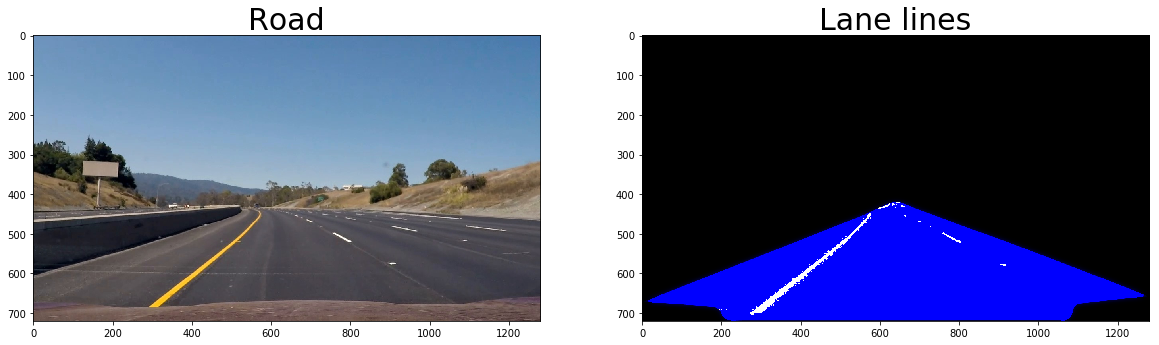

In [3]:
from classes import RoadImage, CameraCalibration

cal = CameraCalibration('camera_cal/validation.p')
mask = RoadImage(filename='training/straight_mask.png')

#crop = ((0,300),(1280,680))
crop = ((0,0),(1280,720))
#file = 'hard_turn'
#file='straight_lines1'
#file='test5'
file='input0073'
img = RoadImage(filename='test_images/'+file+'.jpg')

# Display img and warped image
import matplotlib.pyplot as plt
%matplotlib inline

lines = img.extract_lines(cal, crop=crop)

lines.save('output_images/lines_'+file+'.png')

import numpy as np
result = np.zeros_like(img, dtype=np.float32)
result.channel(0)[:] = lines
result.channel(1)[:] = lines
result.channel(2)[:] = mask

f, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
img.show(ax1, title='Road')
result.show(ax2, title='Lane lines')



Now that the best information from the colors and the gradients is combined, we can warp the image to eliminate the perspective effect.

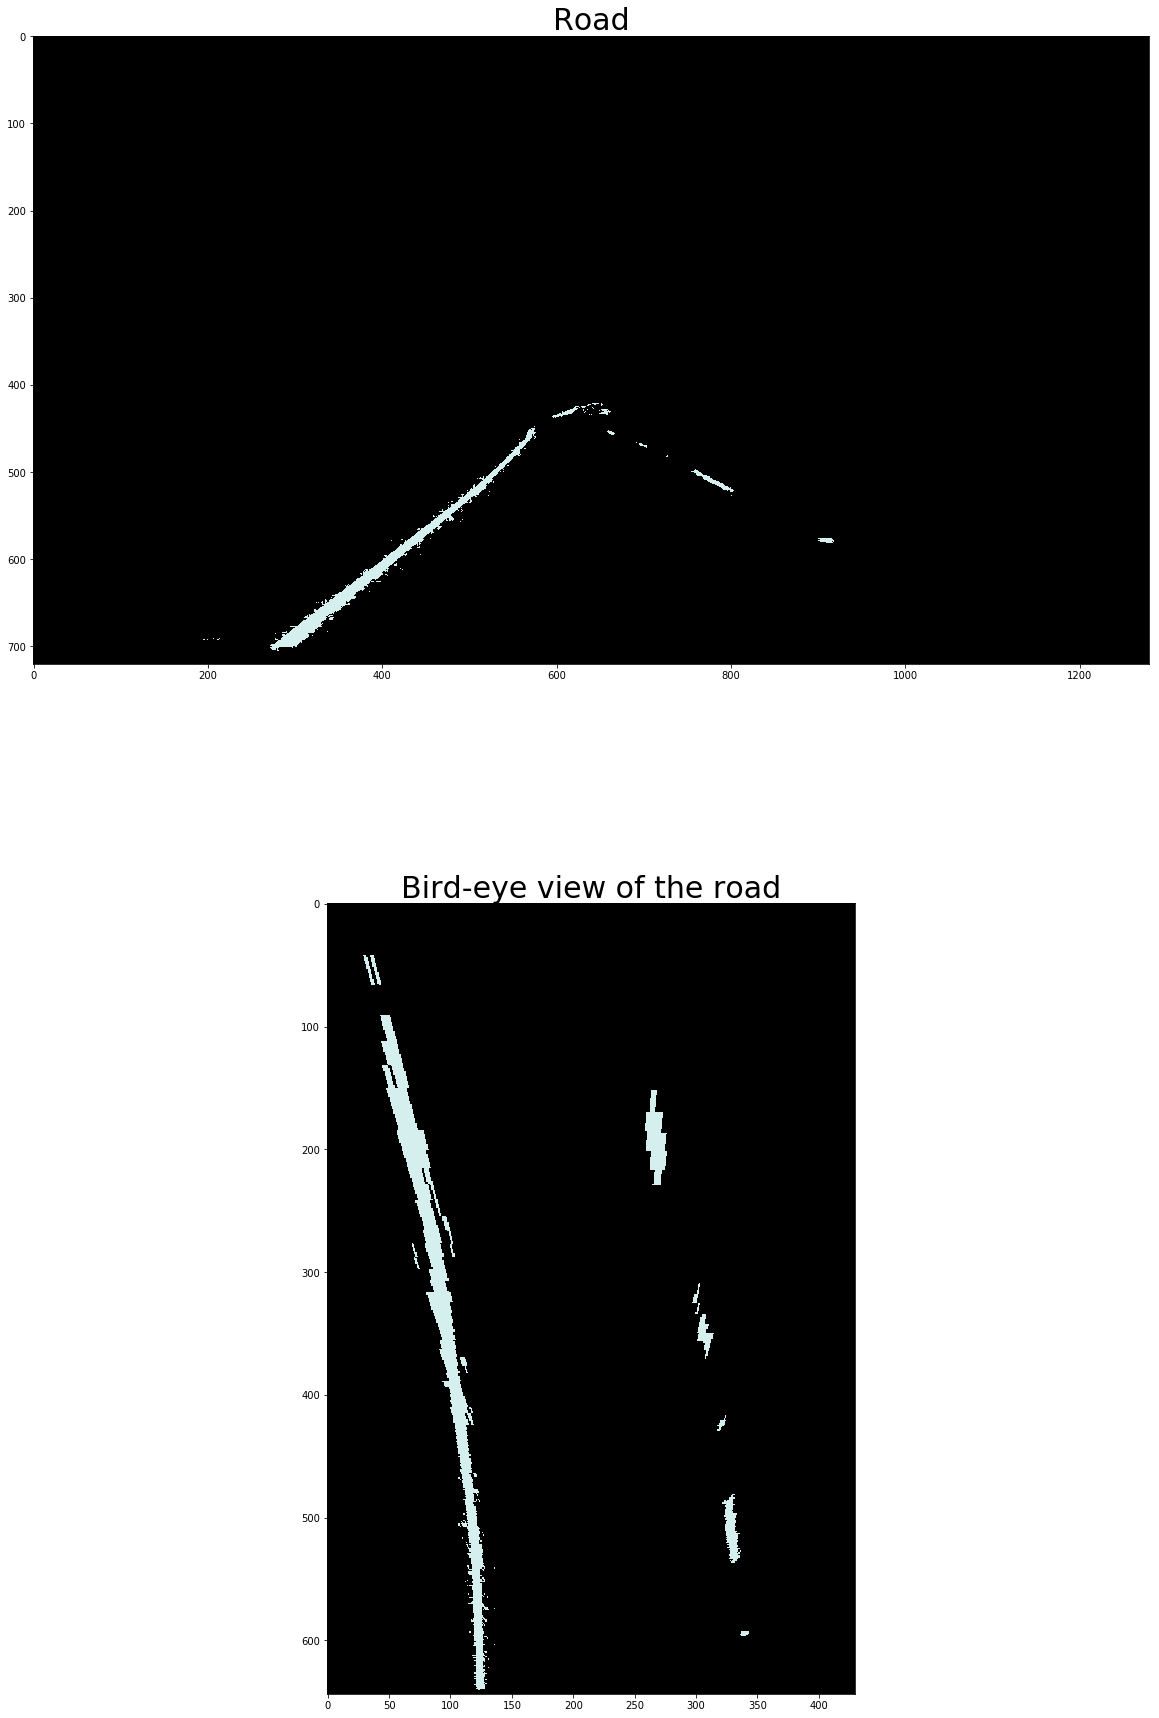

In [5]:
from classes import RoadImage, CameraCalibration
import numpy as np
import cv2

#file = 'hard_turn'
file = 'straight_lines1'
#file = 'test5'
#file = 'test6'
file = { 'n':'input0073', 'h':-0.2 }

img = RoadImage(filename='output_images/lines_'+file['n']+'.png').channel(1).to_float()

cal = CameraCalibration('camera_cal/validation.p')
cal.set_camera_height(1.44)
cal.set_ahead(638,418)

w = img.warp(cal, h=file['h'])
# For hard_turn
#w = img.warp(cal, z=20, scale=(.02,.02), curvrange=(-0.001, 0.05))

#img = cv2.resize(np.array([[0,1]]), img.get_size(), interpolation=cv2.INTER_NEAREST)
#img = RoadImage(img, src_cspace='GRAY')
#print(img.shape, RoadImage.image_channels(img))

# Display img and warped image
import matplotlib.pyplot as plt
%matplotlib inline

f, (ax1,ax2) = plt.subplots(2,1, figsize=(20,32))
img.show(ax1, title='Road')
w.show(ax2, title='Bird-eye view of the road')

w.save('output_images/warped_'+file['n']+'.png')


Validation of class Line

Importing the module. Listing registered implementations.

In [13]:
from classes import Line
print('Available Line implementations:', Line.Implementations())
try:
    Line.Set_Default('totoline')
except ValueError as e:
    print(str(e))
print('Default Line implementation:', Line.Get_default())
try:
    line = Line.Factory()
except ValueError as e:
    print(str(e))
# Call __init__ directly
try:
    line = Line()
except TypeError as e:
    print(str(e))

from classes import LinePoly
# LinePoly becomes the default implementation
print('Available Line implementations:', Line.Implementations())
print('Default Line implementation:', Line.Get_default())
line = Line.Factory()
print('Got a',type(line))

Available Line implementations: ['poly3']
Line.Set_default: totoline is not a registered implementation of Line.
Default Line implementation: LinePoly
Can't instantiate abstract class Line with abstract methods estimate, eval
Available Line implementations: ['poly3']
Default Line implementation: LinePoly
Got a <class 'classes.LinePoly.LinePoly'>


Lines Validation

Perform estimates, evaluation and rendering

Loaded road image. Size = (1280, 720)  #ch: 3
Loaded training/straight_mask.png.
Order 2 forced, inflexion at 34.6171214144 m. Nb pts = 1158


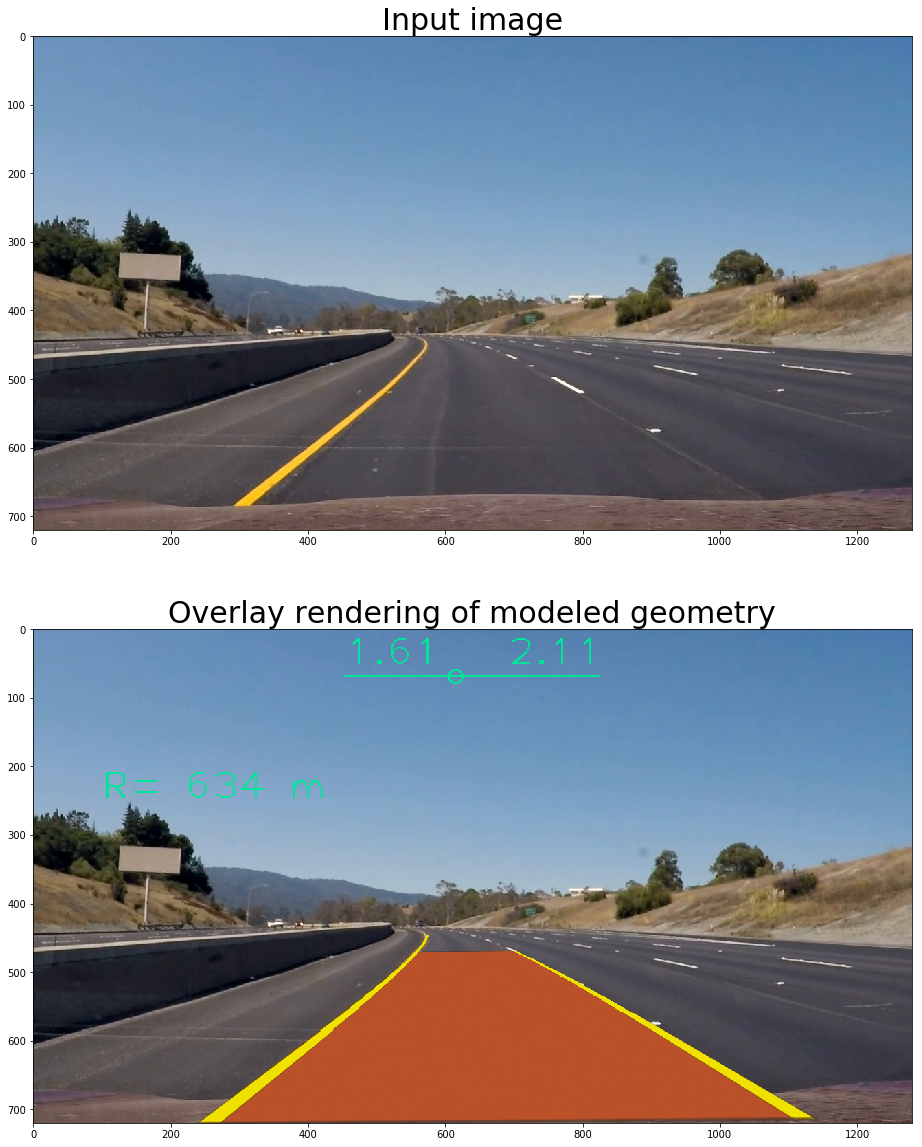

In [1]:
from classes import RoadImage, CameraCalibration,Line

#file ={ 'n':'hard_turn', 'h':0 }
#file = { 'n':'straight_lines1', 'h':-0.186 }
#file = 'test5'
#file = 'test6'
file = { 'n':'crash', 'h':0 }
file = { 'n':'input0073', 'h':-0.2 }

img = RoadImage(filename='test_images/'+file['n']+'.jpg')
#lines = RoadImage(filename='output_images/centroids'+file+'.jpg')

print('Loaded road image. Size =', img.get_size(),
      ' #ch:', RoadImage.image_channels(img))

cal = CameraCalibration('camera_cal/validation.p')
# Set the camera harmonization parameters for our car.
cal.set_camera_height(1.275)
cal.set_ahead(638,418)

# Height map
hmap = file['h']

# Do the work
lines = img.find_lines(cal, h=hmap, method = RoadImage.centroids)
#warp = img.warp(cal, h=hmap)
# For hard_turn
#lines = img.find_lines(cal, z=20, scale=(.02,.02),
#                       curvrange=(-0., 0.05), 
#                       method=RoadImage.centroids)

# Display centroids and extracted geometry image
import matplotlib.pyplot as plt
%matplotlib inline

f, (ax1,ax2) = plt.subplots(2,1, figsize=(20,20))
img.show(ax1, title='Input image')
lines.show(ax2, title='Overlay rendering of modeled geometry')


Video image extractor

In [1]:
from classes import RoadImage, CameraCalibration,Line
from classes.decorators import static_vars
from os import unlink

@static_vars(counter=0, save_input=73)
def extract_image(image):
    img = RoadImage(image, src_cspace='RGB')
    # Do the work
    extract_image.counter += 1
    if extract_image.save_input==extract_image.counter:
        print("Saving image %04d" % extract_image.counter)
        img.save('test_images/input%04d.jpg' 
                 % extract_image.counter, format='jpg')
    if extract_image.save_input<extract_image.counter:
        extract_image.counter=0
        raise StopIteration
    return image[:100,:100]

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

file = 'project_video.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(file).subclip(0,0.1)
clip1 = VideoFileClip(file)
clip = clip1.fl_image(extract_image) #NOTE: this function expects color images!!
clip.write_videofile('ramdisk/remove_me.mp4', audio=False)
unlink('ramdisk/remove_me.mp4')

[MoviePy] >>>> Building video ramdisk/remove_me.mp4
[MoviePy] Writing video ramdisk/remove_me.mp4


  5%|▌         | 68/1261 [00:01<00:32, 37.18it/s]

Saving image 0073


  6%|▌         | 72/1261 [00:02<00:50, 23.46it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: ramdisk/remove_me.mp4 

